In [1]:
from __future__ import division

import numpy as np
import os
from glob import glob
import scipy

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

import pandas as pd
import pickle

In [4]:
# NEURAL 
partial_n = pd.read_csv('/Users/sasha/Documents/sketchfeat_data/filtered_targ_comp_corr_normed.csv')

# partial_n = pd.read_csv('/Users/rachellee/Documents/sketchfeat_data/filtered_targ_comp_corr_normed.csv')


partial_n['control'] = partial_n[['base1corr', 'base2corr']].mean(axis = 1)

In [5]:
# NEURAL 
# metadata from the csv 
subject_names = np.unique(partial_n['subj'])
num_psketch = len(np.unique(partial_n['time_point']))
trials = np.unique(partial_n['trial_num'])
categories = ['bed', 'bench', 'chair', 'table']
runs = np.unique(partial_n['run_num'])
rois = np.unique(partial_n['roi'])

partial_n['trialID'] = partial_n[['subj', 'trial_num']].apply(
                                    lambda x: '{:s}_{:d}'.format(x[0], x[1]), axis = 1)

print ('Number of subjects: {:d}'.format(len(subject_names)))
print ('Number of partial skecthes: {:d}'.format(num_psketch))
print ('Number of trials per subject: {:d}'.format(len(trials)))
print ('Number of rois per subject: {:d}'.format(len(rois)))
print(rois)

Number of subjects: 31
Number of partial skecthes: 23
Number of trials per subject: 40
Number of rois per subject: 10
['IT' 'LOC' 'PRC' 'V1' 'V2' 'ento' 'fusiform' 'hipp' 'mOFC' 'parahippo']


In [6]:
# NEURAL 
rois = ['IT', 'LOC', 'PRC', 'V1', 'V2', 
        'ento', 'fusiform', 'hipp', 'mOFC', 'parahippo']
lims = [(-0.02,0.02), (-0.1,0.06), (-0.01,0.01), (-0.1,0.05), (-0.1,0.1), 
        (-0.01,0.01), (-0.1,0.05), (-0.01,0.01), (-0.01,0.01), (-0.01,0.01)]
#lims = [(-0.5,0.5)]*10
yaxdict = dict(zip(rois,lims))

In [7]:
# MODEL 
partial = pd.read_csv('/Users/sasha/Documents/sketchfeat_data/partial_sketch_full.csv')

# partial = pd.read_csv('/Users/rachellee/Documents/sketchfeat_data/partial_sketch_full.csv')

partial['curr_winner'] = partial[['bed', 'bench', 'chair', 'table']].idxmax(axis = 1)
partial['tc_pair'] = partial[['target', 'competitor']].apply(
                                    lambda x: '{:s}/{:s}'.format(x[0], x[1]), axis = 1)
partial['trialID'] = partial[['wID', 'trial']].apply(
                                    lambda x: '{:s}_{:d}'.format(x[0], x[1]), axis = 1)
partial['run'] = partial['trial'].apply(
                                    lambda x: np.floor((x - 300)/10) - 1)


def convert_label_to_index(labels):
    labels[labels == 'bed'] = 9
    labels[labels == 'bench'] = 10
    labels[labels == 'chair'] = 11
    labels[labels == 'table'] = 12
    labels = [int(x) for x in labels]
    return labels
    
    
target_labels = convert_label_to_index(np.copy(partial['target'].values))
comp_labels = convert_label_to_index(np.copy(partial['competitor'].values))
controls = np.array([np.setdiff1d(np.arange(9,13), x) for x in np.column_stack([target_labels, comp_labels])])
control1 = controls[:,0]
control2 = controls[:,1]

partial['target_val'] = partial.values[np.arange(len(partial)), target_labels]
partial['competitor_val'] = partial.values[np.arange(len(partial)), comp_labels]
partial['control_val'] = np.mean(np.array([partial.values[np.arange(len(partial)), control1], partial.values[np.arange(len(partial)), control2]]), axis = 0)


# metadata from the csv 
subject_names = np.unique(partial['wID'])
num_psketch = len(np.unique(partial['numSketch']))
trials = np.unique(partial['trial'])
categories = ['bed', 'bench', 'chair', 'table']
tc_pairs = np.unique(partial['tc_pair'])
runs = np.unique(partial['run'])
print ('Number of subjects: {:d}'.format(len(subject_names)))
print ('Number of partial skecthes: {:d}'.format(num_psketch))
print ('Number of trials per subject: {:d}'.format(len(trials)))
print ('Number of target/competitor pairs: {:d}'.format(len(tc_pairs)))

Number of subjects: 35
Number of partial skecthes: 23
Number of trials per subject: 40
Number of target/competitor pairs: 12


In [8]:
# reconciling neural and model data-- neural data took out 2 of the subjects
# rename column name from 'wID' to the more intuitive 'subj'
partial = partial.rename(index=str, columns={"wID": "subj"})

missing_subj = np.setdiff1d(np.unique(partial['subj']), partial_n['subj'])
mask = partial['subj'].isin(missing_subj)
partial = partial[~mask];



In [9]:
# helper functions 


def plot_average_response(data_in, roi, show_legend = 1):
    figure = plt.figure(figsize = (20, 10))
    
    df = data_in[data_in['roi']==roi]

    sns.tsplot(data = df, time = 'time_point', unit = 'trialID', value = 'targ_corr', color = 'b')
    sns.tsplot(data = df, time = 'time_point', unit = 'trialID', value = 'comp_corr', color = 'r')
    sns.tsplot(data = df, time = 'time_point', unit = 'trialID', value = 'control', color = 'g')

    plt.ylabel('Correlation with Perceptual Template')
    plt.title(str(roi))

    yaxlim = yaxdict[str(roi)]
    axes = plt.gca()
    axes.set_ylim(yaxlim)

    if show_legend == 1:
        plt.legend(['target', 'competitor', 'control (avg)'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.savefig(str(roi) + ' BY TR')
        
def plot_average_response_by_run(data_in, roi, num_subplots = 1, s_i = 0):
    figure = plt.figure(figsize = (20, 10))
    df_full = data_in[data_in['roi']==roi]
    for r_i, r in enumerate(runs):
        plt.subplot(num_subplots, len(runs), (s_i * 4)  + r_i + 1)
        df = df_full[df_full['run_num'] == r]
        sns.tsplot(data = df, time = 'time_point', unit = 'trialID', value = 'targ_corr', color = 'b')
        sns.tsplot(data = df, time = 'time_point', unit = 'trialID', value = 'comp_corr', color = 'r')
        sns.tsplot(data = df, time = 'time_point', unit = 'trialID', value = 'control', color = 'g')

        if r_i == 0:
            plt.ylabel('Correlation with Perceptual Template')
        else:
            plt.ylabel('')
        
        plt.title(str(roi))

        yaxlim = yaxdict[str(roi)]
        axes = plt.gca()
        axes.set_ylim(yaxlim)

        if r_i == 3:
            plt.legend(['target', 'competitor', 'control (avg)'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        
#         plt.savefig(str(roi) + ' BY TRRUN')

# I. Averaged Across Subjects

This is the mean evidence for the target/competitor/control1/control2. So this amounts to the averaged version of the first plot. 

/anaconda/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


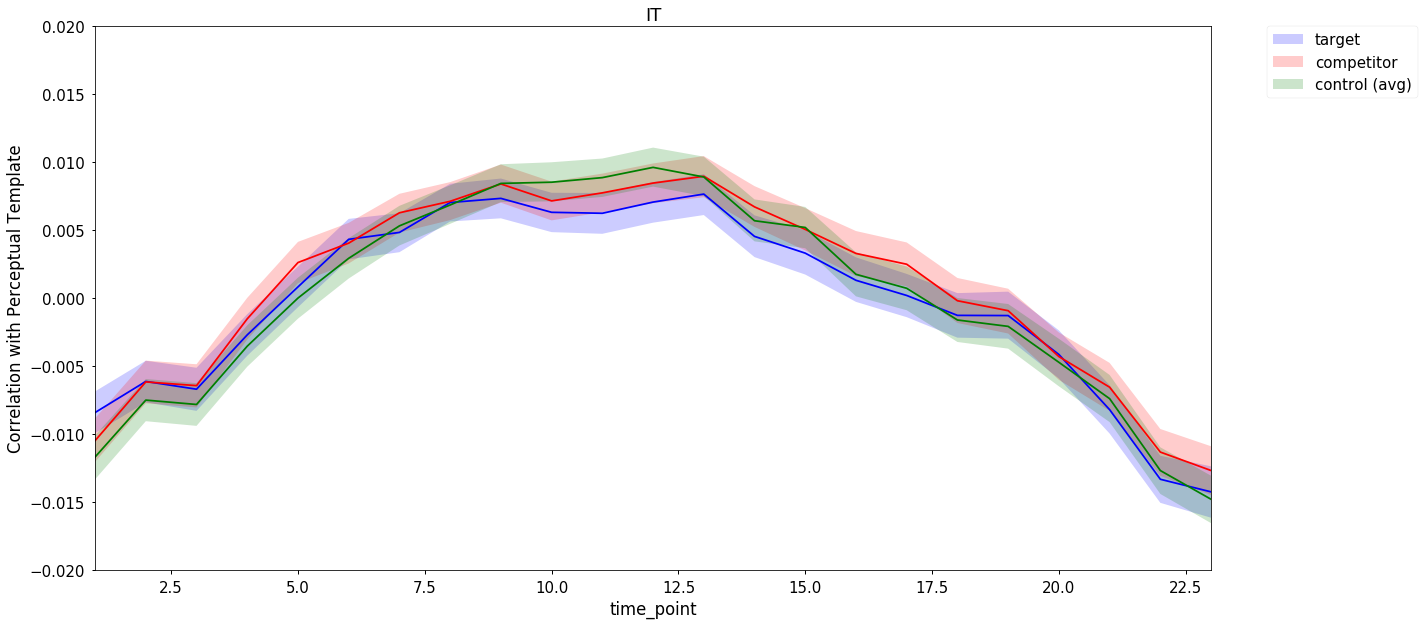

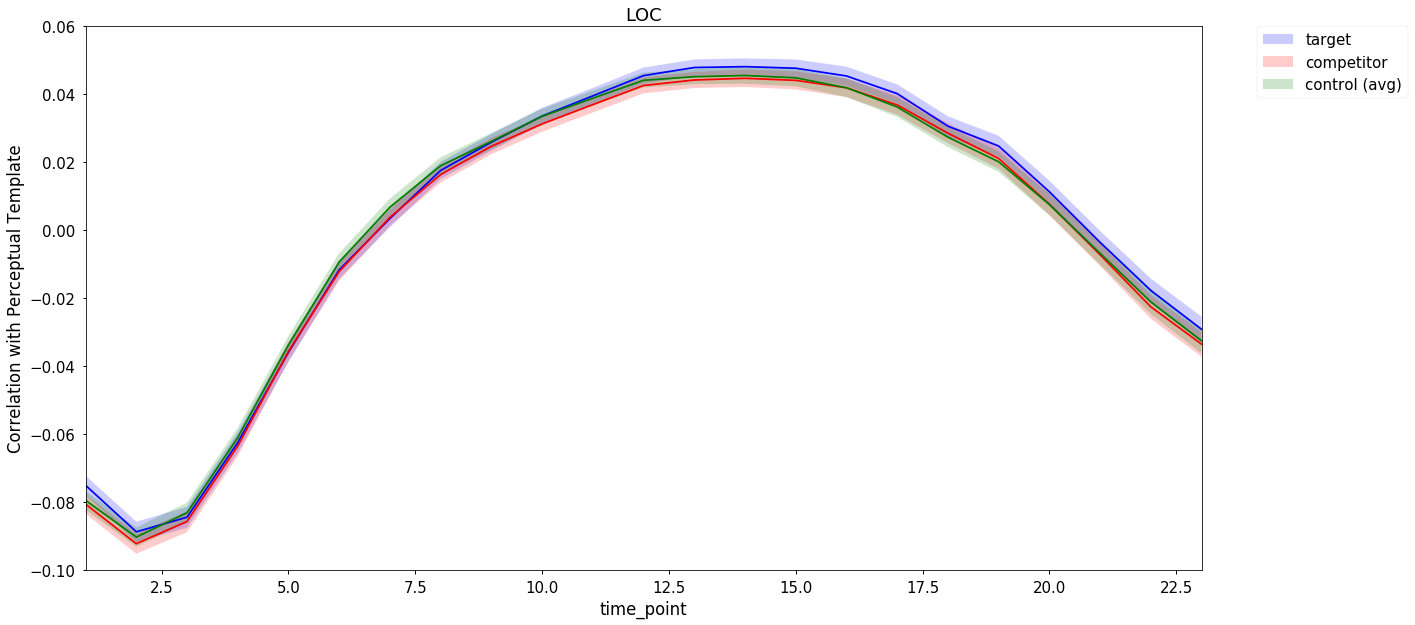

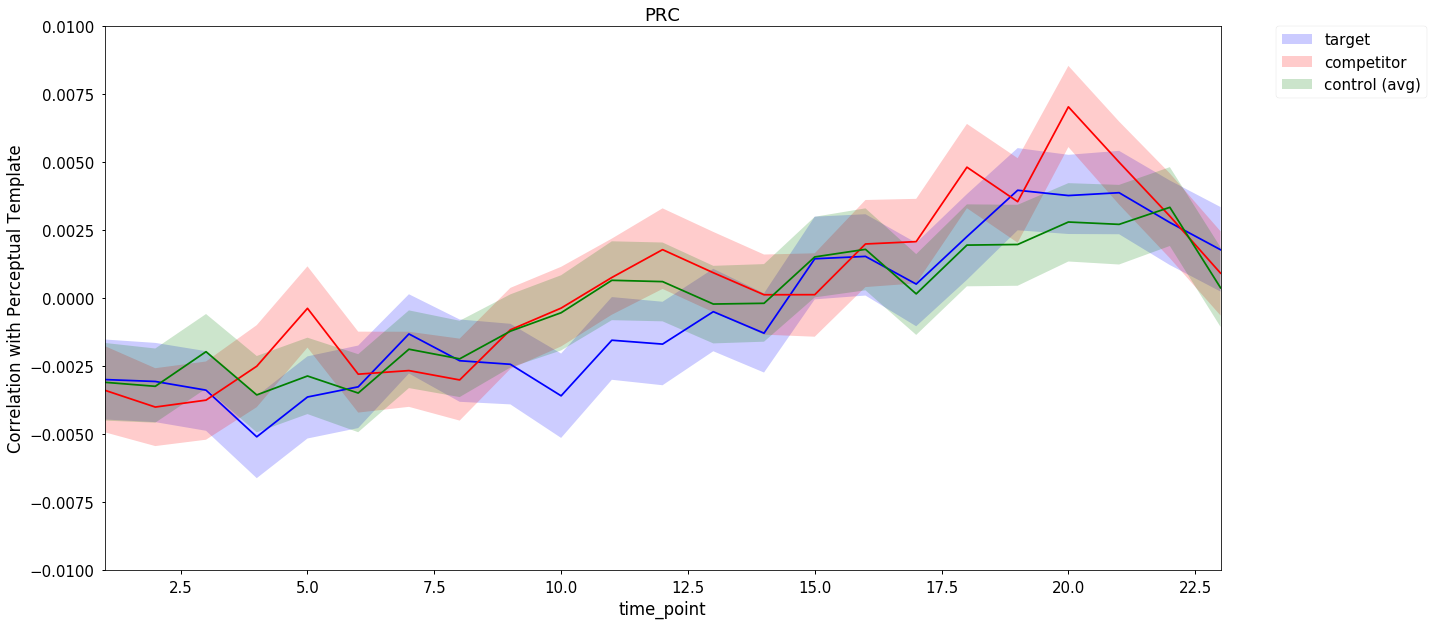

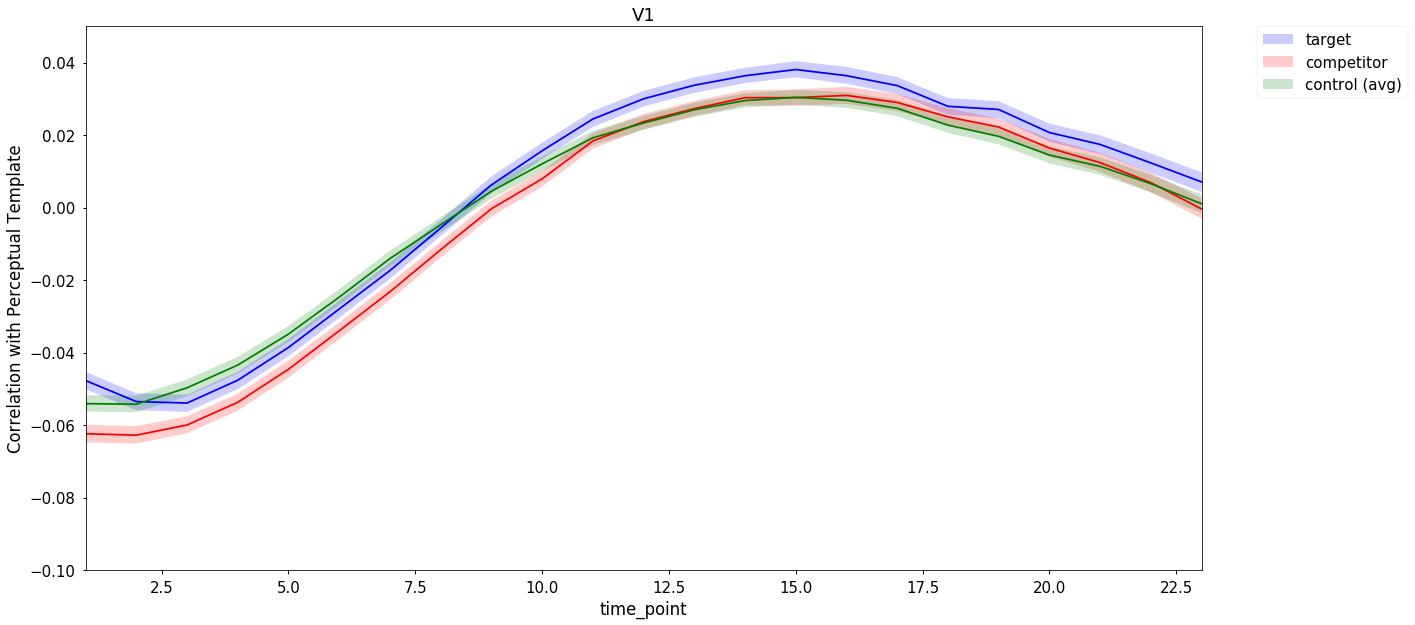

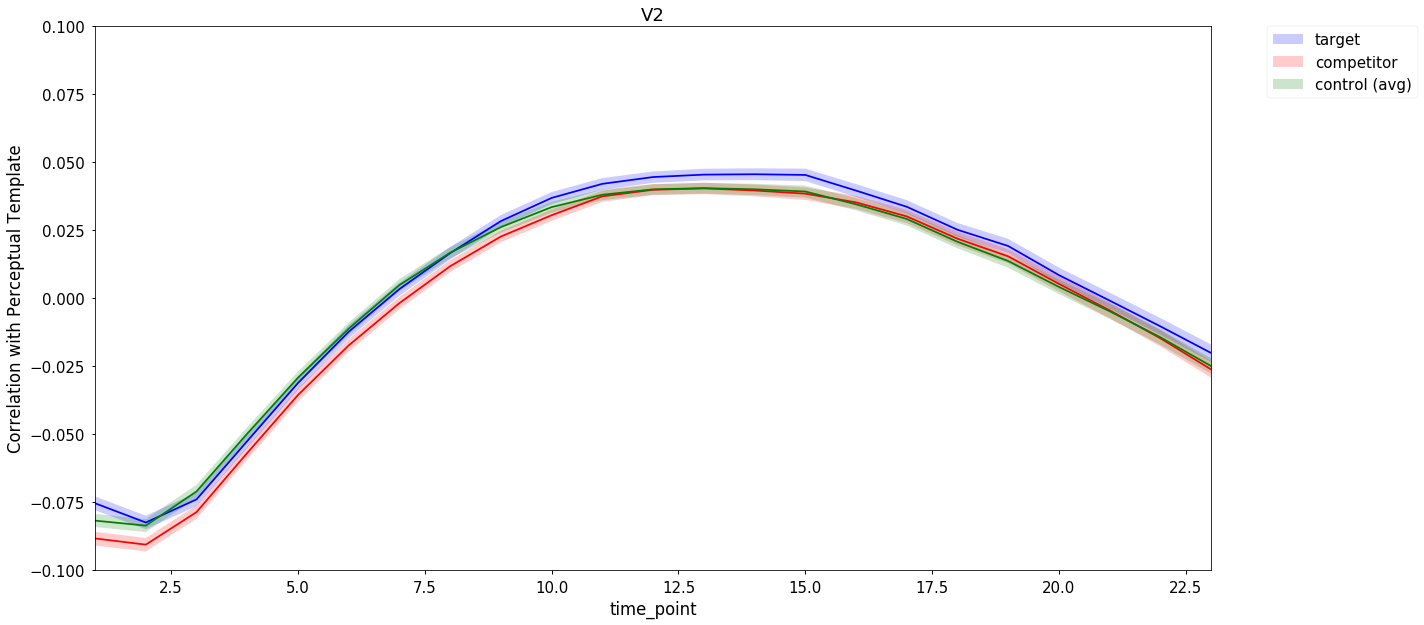

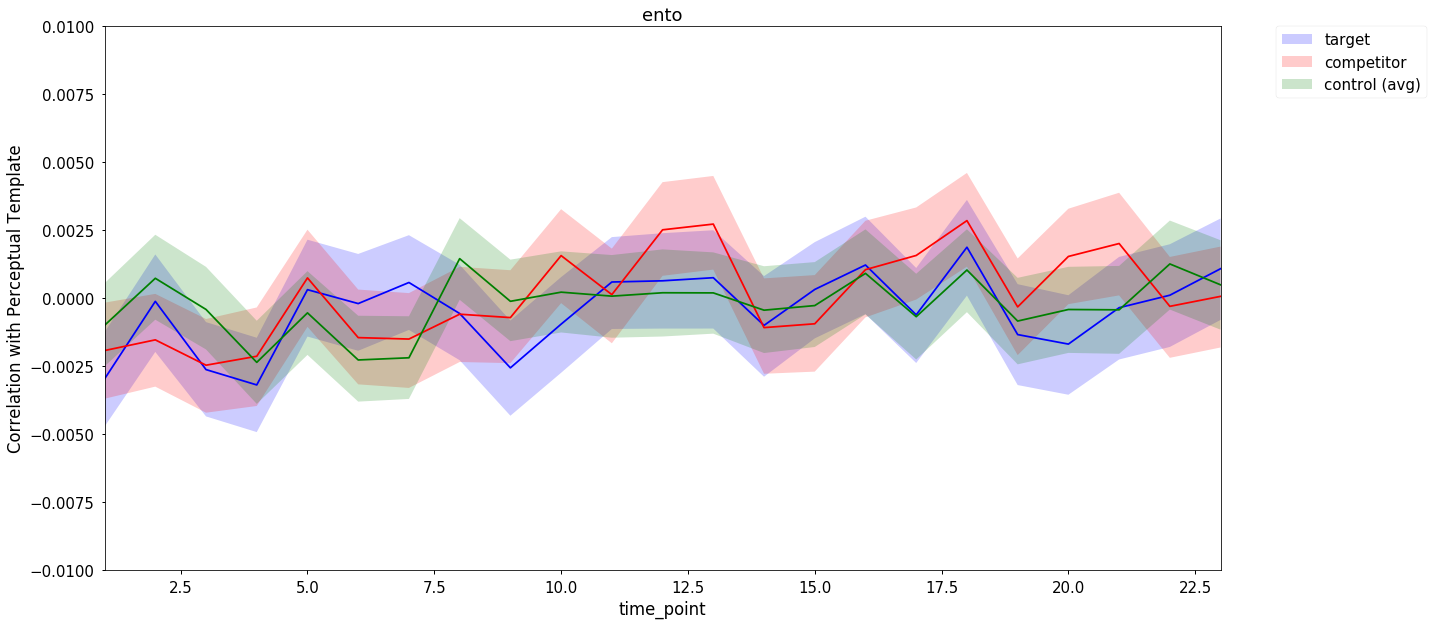

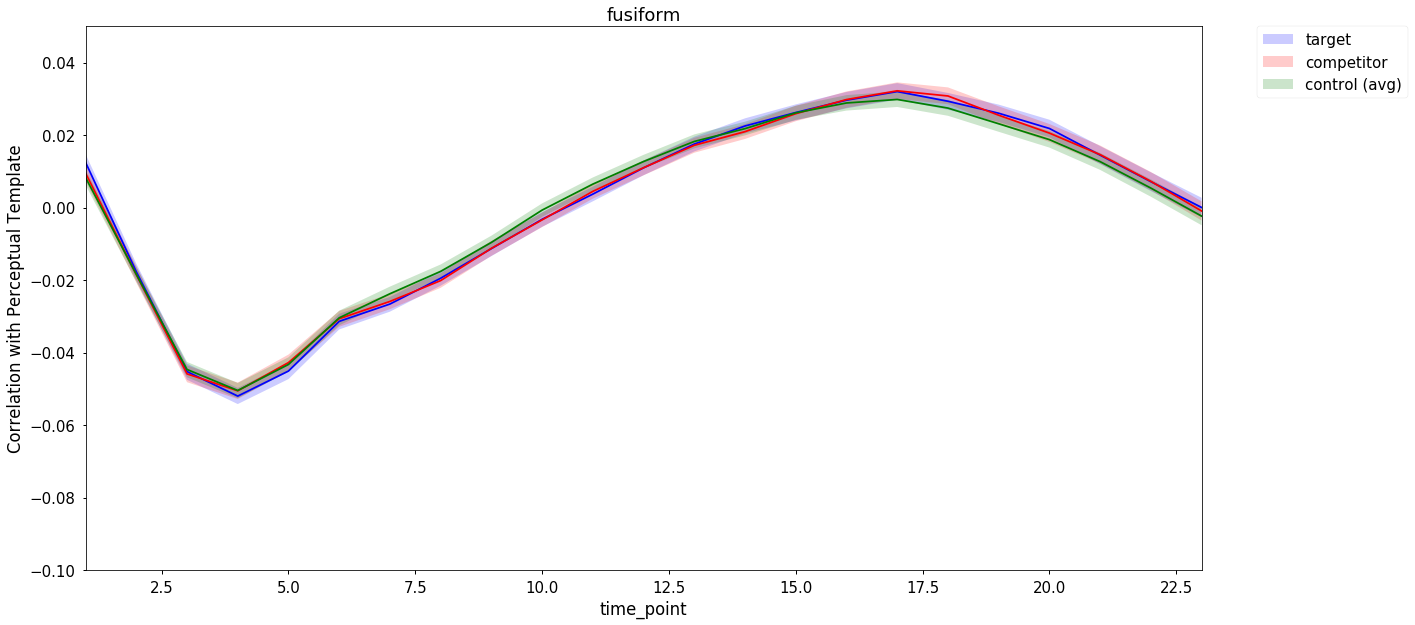

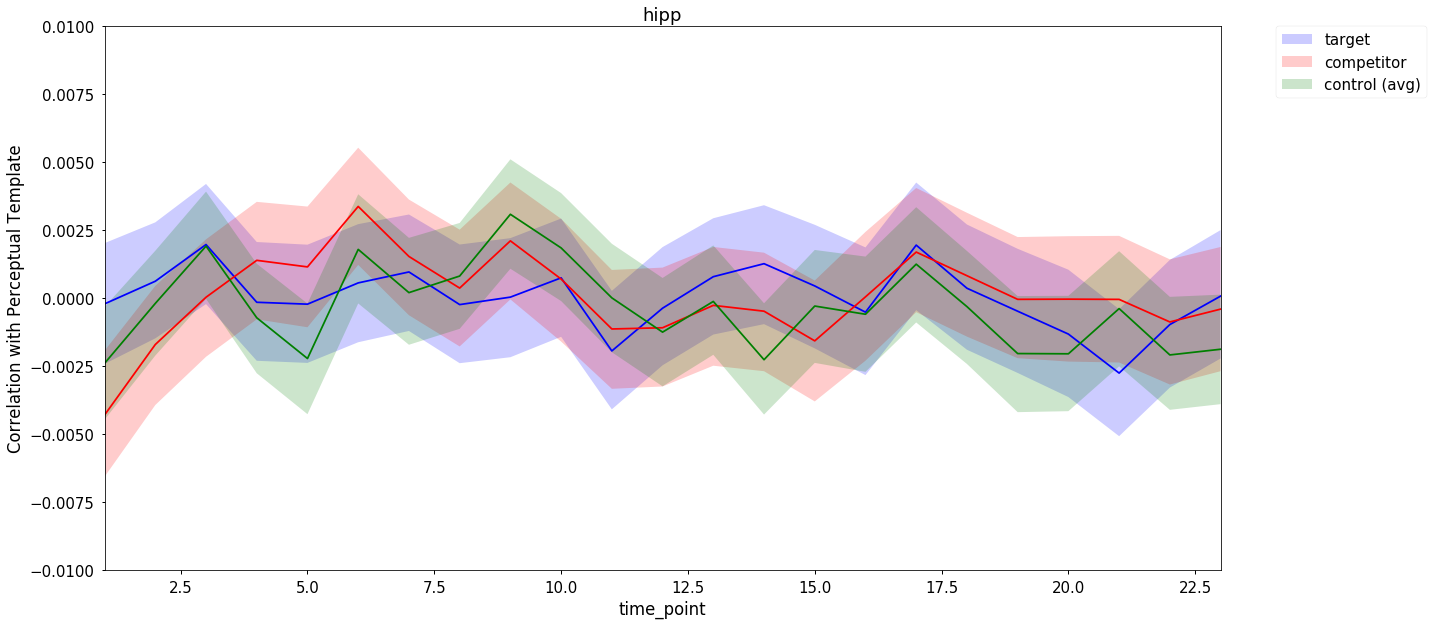

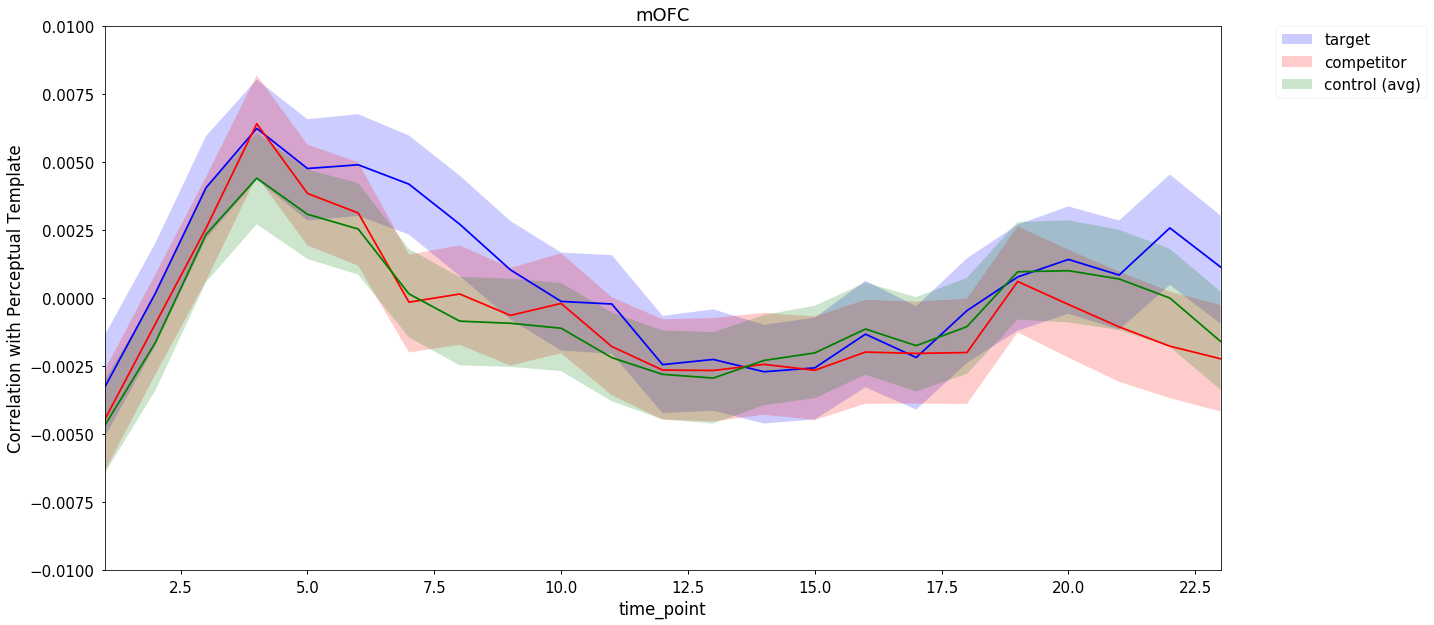

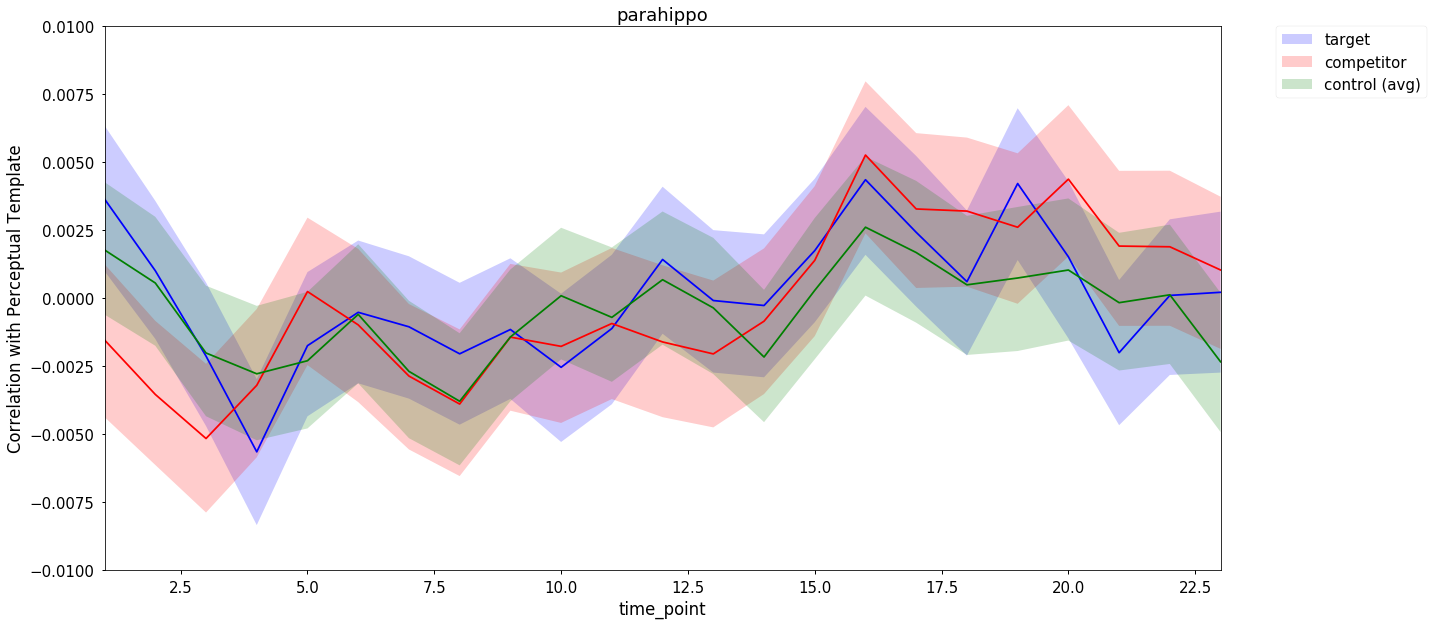

In [8]:
for roi in rois:
    plot_average_response(partial_n, roi)

# II. Collapsing Across Sketch Progression

We now look at the max activation of target vs competitor vs control over the 40 trials for neural and model data


In [10]:
trials = np.unique(partial_n['trial_num'])


data_neural = []


for roi in rois:
    source = 'neural_' + roi;
    partialX = partial_n[partial_n['roi'] == str(roi)]
    for t_i, t in enumerate(trials): 
        partial_i = partialX[partialX['trial_num'] == t]
        max_t = np.mean(partial_i.groupby('subj')['targ_corr'].max())
#         max_loc = partial_i.groupby('subj')['targ_corr'].idxmax()
#         max_t_loc = np.mean(partial_i.loc[max_loc, 'numSketch'])

        max_c = np.mean(partial_i.groupby('subj')['comp_corr'].max())
#         max_loc = partial_i.groupby('subj')['comp_corr'].idxmax()
#         max_c_loc = np.mean(partial_i.loc[max_loc, 'numSketch'])

        max_ct = np.mean(partial_i.groupby('subj')['control'].max())
#         max_loc = partial_i.groupby('subj')['control'].idxmax()
#         max_ct_loc = np.mean(partial_i.loc[max_loc, 'numSketch'])

        avg_t = np.mean(partial_i['targ_corr'])
        avg_c = np.mean(partial_i['comp_corr'])
        avg_ct = np.mean(partial_i['control'])
        
#         data_neural.append([source, t, max_t, max_t_loc, max_c, max_c_loc, max_ct, max_ct_loc, avg_t, avg_c, avg_ct])
        
        data_neural.append([source, t, max_t, max_c, max_ct, avg_t, avg_c, avg_ct])








In [11]:
data_model = []
trials = np.unique(partial['trial'])

source = 'model'
for t_i, t in enumerate(trials): 
    partial_i = partial[partial['trial'] == t]
    
    max_t = np.mean(partial_i.groupby('subj')['target_val'].max())
#     max_loc = partial_i.groupby('subj')['target_val'].idxmax()
#     max_t_loc = np.mean(partial_i.loc[max_loc, 'numSketch'])
    
    max_c = np.mean(partial_i.groupby('subj')['competitor_val'].max())
#     max_loc = partial_i.groupby('subj')['competitor_val'].idxmax()
#     max_c_loc = np.mean(partial_i.loc[max_loc, 'numSketch'])

    max_ct = np.mean(partial_i.groupby('subj')['control_val'].max())
#     max_loc = partial_i.groupby('subj')['control_val'].idxmax()
#     max_ct_loc = np.mean(partial_i.loc[max_loc, 'numSketch'])
            
    avg_t = np.mean(partial_i['target_val'])
    avg_c = np.mean(partial_i['competitor_val'])
    avg_ct = np.mean(partial_i['control_val'])
    
    
#     data_model.append([source, t, max_t, max_t_loc, max_c, max_c_loc, max_ct, max_ct_loc, avg_t, avg_c, avg_ct])
    data_model.append([source, t, max_t, max_c, max_ct, avg_t, avg_c, avg_ct])

In [12]:
df_n = pd.DataFrame(data_neural, columns=('source', 'trial', 
                                          'max_target', 'max_competitor', 'max_control', 
                                          'avg_target','avg_competitor', 'avg_control'))

df_m = pd.DataFrame(data_model, columns=('source', 'trial', 
                                          'max_target', 'max_competitor', 'max_control', 
                                          'avg_target','avg_competitor', 'avg_control'))




partial_nm = pd.concat([df_n, df_m]).reset_index()



## correlate ROI's with model data

In [56]:
roi_corr = []
for roi in rois:

    src = 'neural_' + roi;
    partial_n_i = partial_nm[partial_nm['source'] == src];
    partial_m = partial_nm[partial_nm['source'] == 'model']
    for measure in ['max','avg']:
        
        
        target_corr = (np.corrcoef(partial_n_i[measure + '_target'], partial_m[measure + '_target']))[0, 1]
        competitor_corr = (np.corrcoef(partial_n_i[measure + '_competitor'], partial_m[measure + '_competitor']))[0, 1]
        control_corr = (np.corrcoef(partial_n_i[measure + '_control'], partial_m[measure + '_control']))[0, 1]

        roi_corr.append([roi, measure, target_corr, competitor_corr, control_corr])
        
df_corr = pd.DataFrame(roi_corr, columns=('roi_corr', 'measure', 'target', 'competitor', 'control'))

In [13]:
roi_corr = []
for roi in rois:

    src = 'neural_' + roi;
    partial_n_i = partial_nm[partial_nm['source'] == src];
    partial_m = partial_nm[partial_nm['source'] == 'model']
    for measure in ['max','avg']:
        
        for group in ['target', 'competitor', 'control']:
            corr = (np.corrcoef(partial_n_i[measure + '_' + group], 
                                partial_m[measure + '_' + group]))[0, 1]

            roi_corr.append([roi, measure, group, corr])
        
df_corr = pd.DataFrame(roi_corr, columns=('roi_corr', 'measure', 'group', 'corr'))

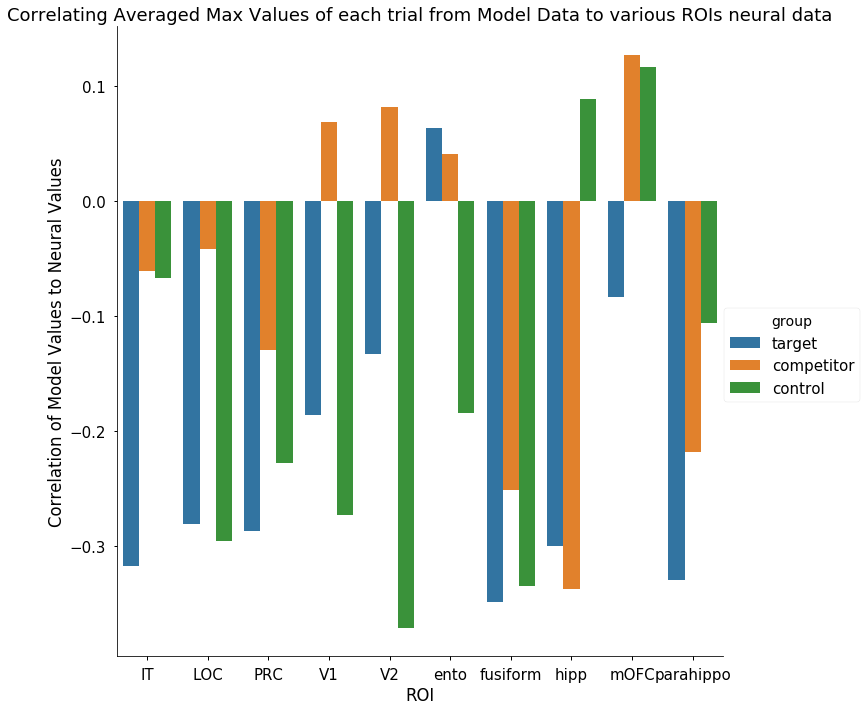

In [14]:
figure = plt.figure(figsize = (10, 5))

sns.factorplot(data = df_corr[df_corr['measure'] == 'max'], x = 'roi_corr', y = 'corr', 
              hue = 'group', kind = 'bar', size = 10)
plt.xlabel('ROI')
plt.ylabel('Correlation of Model Values to Neural Values')
plt.title('Correlating Averaged Max Values of each trial from Model Data to various ROIs neural data')

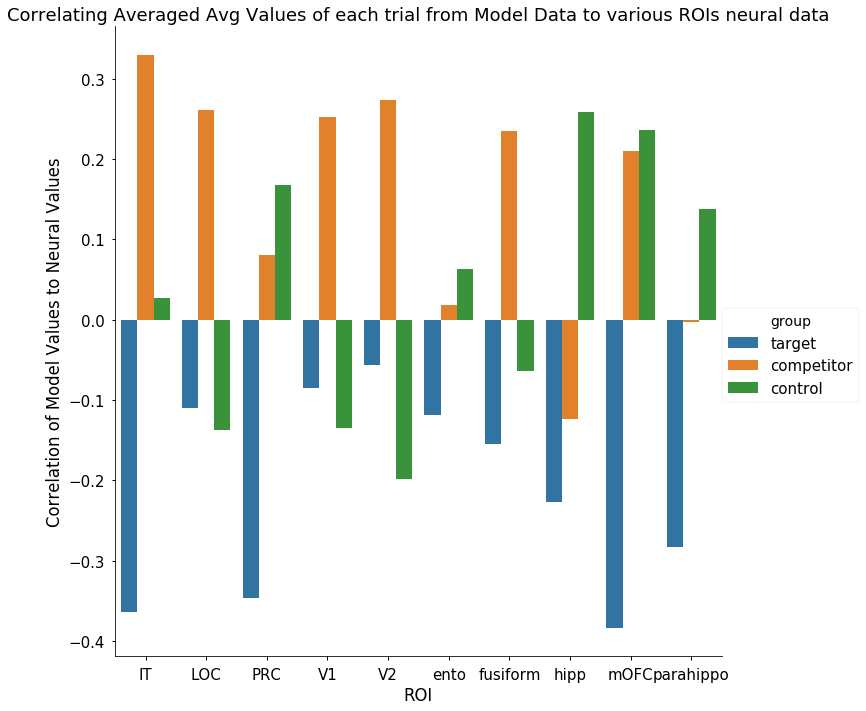

In [65]:
figure = plt.figure(figsize = (10, 5))

sns.factorplot(data = df_corr[df_corr['measure'] == 'avg'], x = 'roi_corr', y = 'corr', 
              hue = 'group', kind = 'bar', size = 10)
plt.xlabel('ROI')
plt.ylabel('Correlation of Model Values to Neural Values')
plt.title('Correlating Averaged Avg Values of each trial from Model Data to various ROIs neural data')

# with error bars from subjects

In [18]:
trials = np.unique(partial_n['trial_num'])

subjects = np.unique(partial_n['subj'])
data_neural = []


for roi in rois:
    source = 'neural_' + roi;
    partialX = partial_n[partial_n['roi'] == str(roi)]
    for s_i, subj in enumerate(subjects): 
        
        for t_i, t in enumerate(trials): 
            partial_i = partialX[(partialX['trial_num'] == t) & 
                                (partialX['subj'] == subj)]
            max_t = np.mean(partial_i.groupby('subj')['targ_corr'].max())
    #         max_loc = partial_i.groupby('subj')['targ_corr'].idxmax()
    #         max_t_loc = np.mean(partial_i.loc[max_loc, 'numSketch'])

            max_c = np.mean(partial_i.groupby('subj')['comp_corr'].max())
    #         max_loc = partial_i.groupby('subj')['comp_corr'].idxmax()
    #         max_c_loc = np.mean(partial_i.loc[max_loc, 'numSketch'])

            max_ct = np.mean(partial_i.groupby('subj')['control'].max())
    #         max_loc = partial_i.groupby('subj')['control'].idxmax()
    #         max_ct_loc = np.mean(partial_i.loc[max_loc, 'numSketch'])

            avg_t = np.mean(partial_i['targ_corr'])
            avg_c = np.mean(partial_i['comp_corr'])
            avg_ct = np.mean(partial_i['control'])

    #         data_neural.append([source, t, max_t, max_t_loc, max_c, max_c_loc, max_ct, max_ct_loc, avg_t, avg_c, avg_ct])

            data_neural.append([source, subj, t, max_t, max_c, max_ct, avg_t, avg_c, avg_ct])








In [19]:
data_model = []
trials = np.unique(partial['trial'])
subjects = np.unique(partial['subj'])

source = 'model'
for s_i, subj in enumerate(subjects):
    for t_i, t in enumerate(trials): 
        partial_i = partial[(partial['trial'] == t)& 
                                (partial['subj'] == subj)]

        max_t = np.mean(partial_i.groupby('subj')['target_val'].max())
    #     max_loc = partial_i.groupby('subj')['target_val'].idxmax()
    #     max_t_loc = np.mean(partial_i.loc[max_loc, 'numSketch'])

        max_c = np.mean(partial_i.groupby('subj')['competitor_val'].max())
    #     max_loc = partial_i.groupby('subj')['competitor_val'].idxmax()
    #     max_c_loc = np.mean(partial_i.loc[max_loc, 'numSketch'])

        max_ct = np.mean(partial_i.groupby('subj')['control_val'].max())
    #     max_loc = partial_i.groupby('subj')['control_val'].idxmax()
    #     max_ct_loc = np.mean(partial_i.loc[max_loc, 'numSketch'])

        avg_t = np.mean(partial_i['target_val'])
        avg_c = np.mean(partial_i['competitor_val'])
        avg_ct = np.mean(partial_i['control_val'])


    #     data_model.append([source, t, max_t, max_t_loc, max_c, max_c_loc, max_ct, max_ct_loc, avg_t, avg_c, avg_ct])
        data_model.append([source, subj, t, max_t, max_c, max_ct, avg_t, avg_c, avg_ct])

In [20]:
df_n = pd.DataFrame(data_neural, columns=('source', 'subj', 'trial', 
                                          'max_target', 'max_competitor', 'max_control', 
                                          'avg_target','avg_competitor', 'avg_control'))

df_m = pd.DataFrame(data_model, columns=('source', 'subj', 'trial', 
                                          'max_target', 'max_competitor', 'max_control', 
                                          'avg_target','avg_competitor', 'avg_control'))




partial_nm = pd.concat([df_n, df_m]).reset_index()



In [21]:
roi_corr = []
for roi in rois:

    src = 'neural_' + roi;
    
    for subj in subjects: 
        partial_n_i = partial_nm[(partial_nm['source'] == src) & 
                                (partial_nm['subj'] == subj)];
        partial_m = partial_nm[(partial_nm['source'] == 'model') &
                              (partial_nm['subj'] == subj)]
        for measure in ['max','avg']:


            for group in ['target', 'competitor', 'control']:
                corr = (np.corrcoef(partial_n_i[measure + '_' + group], 
                                    partial_m[measure + '_' + group]))[0, 1]

                roi_corr.append([roi, subj, measure, group, corr])
        
df_corr = pd.DataFrame(roi_corr, columns=('roi_corr', 'subj', 'measure', 'group', 'corr'))

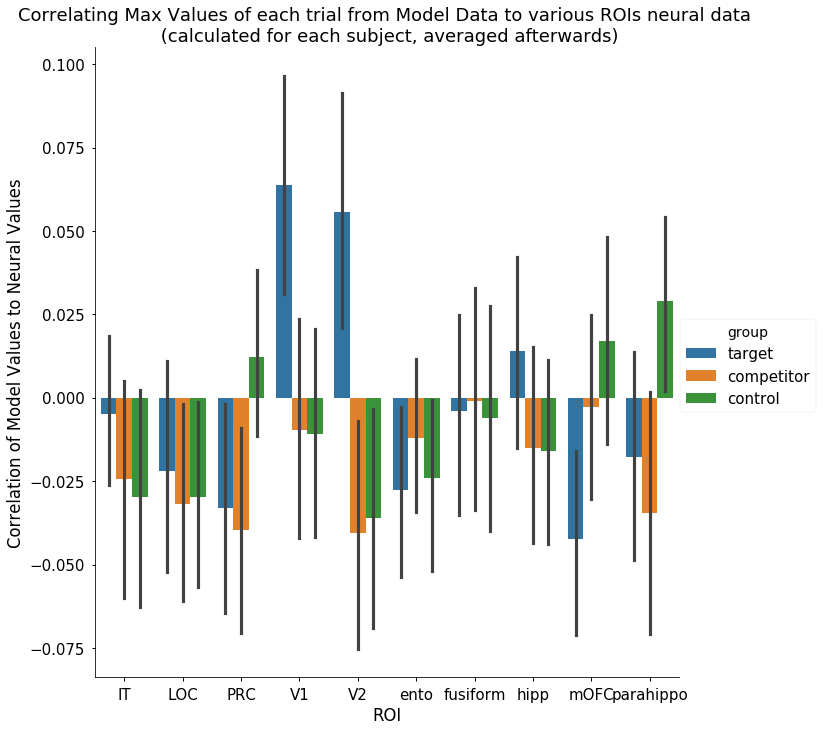

In [35]:
figure = plt.figure(figsize = (10, 5))

sns.factorplot(data = df_corr[df_corr['measure'] == 'max'], x = 'roi_corr', y = 'corr', 
              hue = 'group', kind = 'bar', size = 10, ci = 68.2)
plt.xlabel('ROI')
plt.ylabel('Correlation of Model Values to Neural Values')
plt.title('Correlating Max Values of each trial from Model Data to various ROIs neural data \n (calculated for each subject, averaged afterwards)')

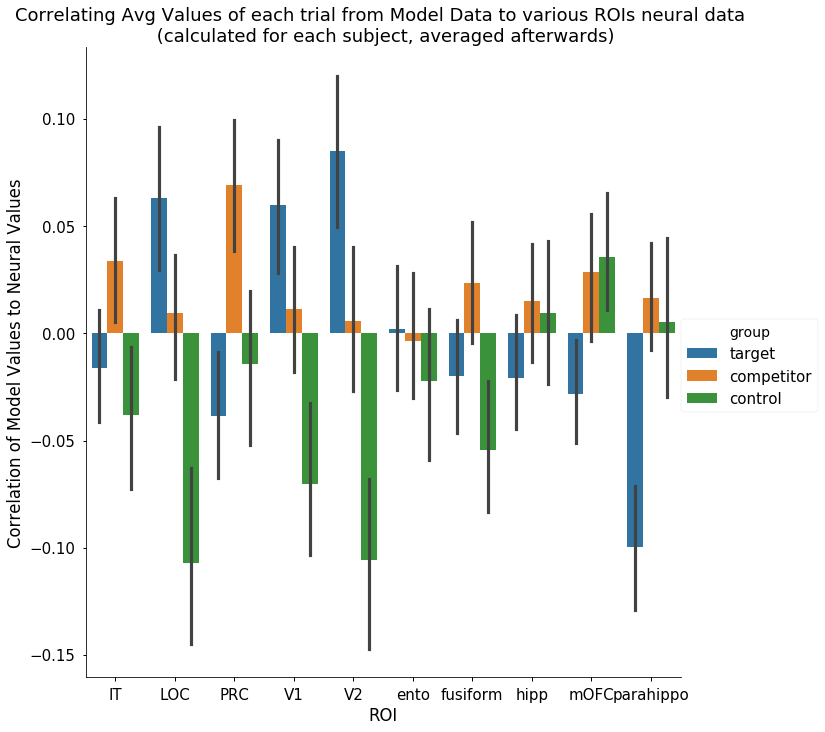

In [37]:
figure = plt.figure(figsize = (10, 5))

sns.factorplot(data = df_corr[df_corr['measure'] == 'avg'], x = 'roi_corr', y = 'corr', 
              hue = 'group', kind = 'bar', size = 10, ci = 68.2)
plt.xlabel('ROI')
plt.ylabel('Correlation of Model Values to Neural Values')
plt.title('Correlating Avg Values of each trial from Model Data to various ROIs neural data \n (calculated for each subject, averaged afterwards)')